In [1]:
# Download all the libraries 
%pylab inline

import matplotlib.pyplot as plt
import torch
import torchvision
import numpy
import os
import pinecone
from PIL import Image

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# read the data 
dataset_dir = 'graphs'
dataset_files = os.listdir(dataset_dir)
len(dataset_files)
data = dataset_files[:5]

In [97]:
# lets visualize the data by seeing the pictures 
def show_images_horizontally(file_names):
    m = len(file_names)
    fig, ax = plt.subplots(1,m)
    fig.set_figwidth = (10*m)
    for a, f in zip( ax, file_names):
        a. imshow(Image.open('graphs/'+ f))
        a.axis("off")
    plt.show()
    
def show_image(file_name):
    fig, ax = plt.subplots(1,1)
    fig.set_figwidth = (1.3)
    ax.imshow(Image.open('graphs/'+ file_name))
    ax.axis("off")
    

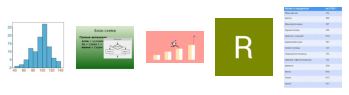

In [4]:
show_images_horizontally(data)

In [5]:
# convert the pictures into vectors using a pre-trained model 
from torchvision import transforms as ts
import torchvision.models as models
from PIL import Image

class Image_Embedder:
    def __init__(self):
        self.normalize = ts.Normalize(mean=[0.485, 0.456,0.406], std = [0.229,0.224, 0.225])
        self.model = models.squeezenet1_0(pretrained = True, progress=False)
        
    def embed (self, i):
        image = Image.open("graphs/"+i).convert("RGB")
        image= ts.Resize(256)(image)
        image= ts.CenterCrop(224)(image)
        tensor=ts.ToTensor()(image)
        tensor=self.normalize(tensor).reshape(1,3,224,224)
        vector=self.model(tensor).cpu().detach().numpy().flatten()
        
        return vector
    
image_embedder = Image_Embedder()

/Users/prarthanapoojara/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prarthanapoojara/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from tqdm import tqdm 
count = 0
temp = []
for i in tqdm(dataset_files):
    a = image_embedder.embed(i)
    b = a.tolist()
    temp.append(b)
        

100%|█████████████████████████████████████| 15875/15875 [05:34<00:00, 47.48it/s]


In [7]:
# take those vectors and put it in a dataframe 
from tqdm import tqdm 
import pandas as pd

df=pd.DataFrame()
df["embedding_id"]= dataset_files
df["embedding"] = temp

df=df.sample(frac=1)


In [8]:
# divide into training and query dataset
cutoff=int(len(df)*0.9)
item_df, query_df = df[:cutoff], df[cutoff:]

In [9]:
# Load Pinecone API key
api_key = '4a72ca4c-1edb-4d92-bd97-987784c4f942'
pinecone.init(
    api_key=api_key,
    environment="us-west4-gcp"  # find next to API key in console
)

In [10]:
index_name="image"
index = pinecone.Index("image")

In [67]:
#upsert
id1 = item_df["embedding_id"][14000:]
vec1 = item_df["embedding"][14000:]

In [68]:
index.upsert(vectors = zip(id1, vec1))

{'upserted_count': 287}

In [69]:
# query 

In [82]:
vec1 = query_df["embedding"][5:10]

In [83]:
res= index.query(queries = vec1, top_k =2)

In [84]:
res

{'results': [{'matches': [{'id': 'table_images36 (3).jpg.jpg',
                           'score': 839.152344,
                           'values': []},
                          {'id': 'bar_chart_images172 (3).jpg.jpg',
                           'score': 891.078125,
                           'values': []}],
              'namespace': ''},
             {'matches': [{'id': 'flow_chart_images487 (2).jpg.jpg',
                           'score': 725.773438,
                           'values': []},
                          {'id': 'flow_chart_blok_shema0.png.jpg',
                           'score': 767.546875,
                           'values': []}],
              'namespace': ''},
             {'matches': [{'id': 'bar_chart_images120 (2).jpg.jpg',
                           'score': 746.960938,
                           'values': []},
                          {'id': 'bar_chart_images410 (2).jpg.jpg',
                           'score': 1613.73438,
                           'value

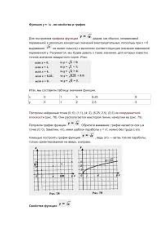

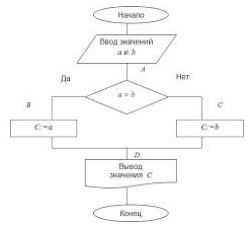

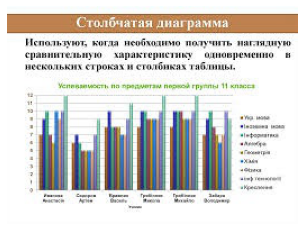

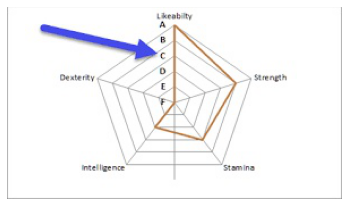

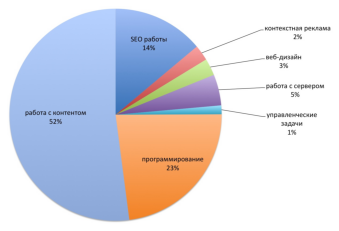

In [87]:
for i in range(5,10):
    show_image(query_df.embedding_id.iloc[i])

In [88]:
list1 =['table_images36 (3).jpg.jpg','bar_chart_images172 (3).jpg.jpg', 'flow_chart_images487 (2).jpg.jpg', 'flow_chart_blok_shema0.png.jpg','bar_chart_images120 (2).jpg.jpg','bar_chart_images410 (2).jpg.jpg','diagram_image11.png.jpg','diagram_Replace-Numbers-with-Text-for-Excel-Radar-Chart-Axis-Values-FI.png.jpg','pie_chart_images467.jpg.jpg','pie_chart_image7 (2).png.jpg']

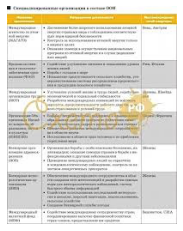

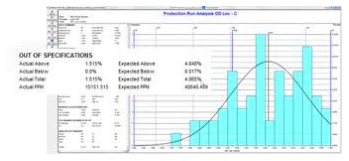

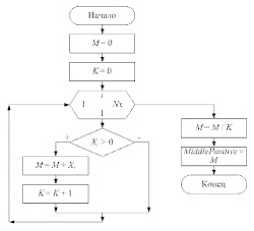

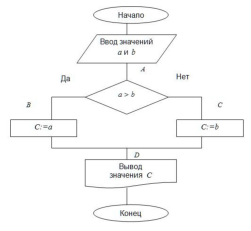

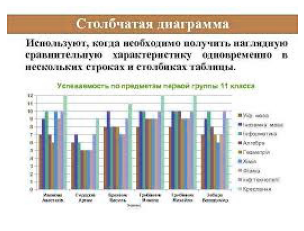

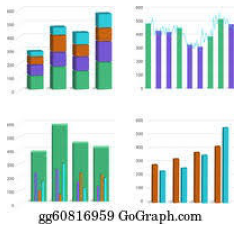

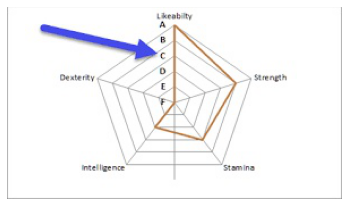

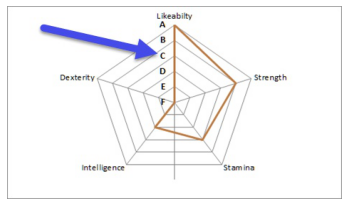

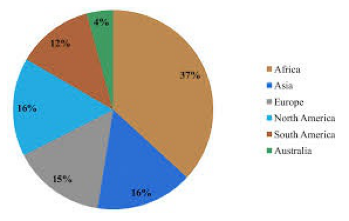

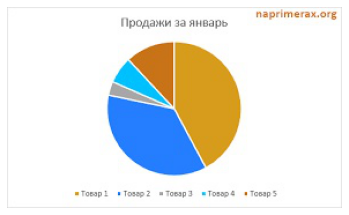

In [100]:
for i in range(10):
    show_image(list1[i])